# Premier League Points By Positions

## Business Understanding

Aim to investigate:

- How do points totals recently compare to early Premier League seasons?
- What has happened to the gap between the champions and relegation survivors?
- How many points do you tend to need to qualify for Europe recently?

## Data Understanding

To answer these questions we will need access to the number of points each Premier League team has achieved across each final position over the history of the Premier League. This is available from www.fbref.com and to access it I will need to use some webscraping with requests and BeautifulSoup.

## Prepare Data

Data preparation involves multiple steps:
1. Find URL to the seasons history for the Premier League on fbref.com.
2. Find the season history table.
3. Loop through each row from table to get the URL for each individual season.
4. For each season URL, find the league table and convert to pandas dataframe.
5. Combine all season's dataframes to a single master dataframe.
6. Remove early seasons with 42 game seasons.
7. Pivot master table to get seasons as index and positions as columns with points as values.
8. Filter for Points by Position per Season.
9. Filter for Champions and Survivors.
10. Filter for Points for Europe.

Luckily there are no missing values.

There are two categorical variables: the seasons and positions. These are used as index and columns respectively after pivoting to enable visualisation in correct grouping.

I didn't look for outliers to remove as they are required to be included, the outliers are interesting and can help us understand the trends in data.

### Package Import

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
def plot_formatting():
    '''
    Set up formatting for plots
    '''
    
    import matplotlib.pyplot as plt
    
    # Set axes formats
    ax.tick_params(axis='x',labelrotation=90)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(False)

### Get Data

##### Find table of season URLs

First need to access the table that stores all the URLs to each respective Premier League season.

In [3]:
def load_table_seasons(url):
    '''
    Get tables from specified url
    
    url (string) - url from fbref.com of premier league season history
    '''
    
    # Send initial request
    response = requests.get(url)
    print(response)

    # Define comments in html
    comm = re.compile("<!--|-->")
    # Remove comments form html
    soup = BeautifulSoup(comm.sub("", response.text), 'lxml')

    # Get all tables
    all_tables = soup.find_all('table')
    
    return all_tables

In [4]:
# Get all tables from url
all_tables = load_table_seasons('https://fbref.com/en/comps/9/history/Premier-League-Seasons')
all_tables

<Response [200]>


[<table class="sortable stats_table" data-cols-to-freeze="2" id="seasons"><caption>Premier League Seasons Table</caption>
 <colgroup><col/><col/><col/><col/><col/></colgroup>
 <thead>
 <tr>
 <th aria-label="Season" class=" poptip center" data-stat="season" data-tip="&lt;strong&gt;Season&lt;/strong&gt;&lt;br&gt;Winter leagues generally run from August to May of the following year.&lt;br&gt;Summer leagues generally run from February to November of the same year." scope="col">Season</th>
 <th aria-label="Name the competition was known as for that season" class=" poptip center" data-stat="league_name" data-tip="Name the competition was known as for that season" scope="col">Competition Name</th>
 <th aria-label="No. of squads participating in competition." class=" poptip center" data-stat="num_squads" data-tip="No. of squads participating in competition." scope="col"># Squads</th>
 <th aria-label="League champion for that season" class=" poptip center" data-stat="champ" data-tip="League cha

##### Get URLs for all seasons

We can loop through the rows in that table to create the full URLs of each Premier League season.

In [5]:
def tables_to_season_urls(all_tables):
    
    '''
    Convert list of tables to list of individual season urls
    
    all_tables (list) - list of html of tables from fbref.com Premier League season history
    
    '''
    
    # From first table, find the 'season' column.
    season_rows = all_tables[0].find_all('th', {'data-stat':'season'})[1:]
    
    # Create empty list to populate with urls
    season_urls = []
    for season in range(len(season_rows)):

        # If the row contains 'a' tag then grab the url using 'href'
        if (season_rows[season].find('a')):
            url = season_rows[season].find('a').get('href')
        else: 
            next

        # Create complete url
        complete_url = 'https://fbref.com' + url
        # Add to url list
        season_urls.append(complete_url)
        
    return season_urls
    

In [6]:
# Get seasons from tables
season_urls = tables_to_season_urls(all_tables)
# This was initially done before 2019/20 season finished, so replicating by removing.
season_urls.remove('https://fbref.com/en/comps/9/3232/2019-2020-Premier-League-Stats')
season_urls

['https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/1889/2018-2019-Premier-League-Stats',
 'https://fbref.com/en/comps/9/1631/2017-2018-Premier-League-Stats',
 'https://fbref.com/en/comps/9/1526/2016-2017-Premier-League-Stats',
 'https://fbref.com/en/comps/9/1467/2015-2016-Premier-League-Stats',
 'https://fbref.com/en/comps/9/733/2014-2015-Premier-League-Stats',
 'https://fbref.com/en/comps/9/669/2013-2014-Premier-League-Stats',
 'https://fbref.com/en/comps/9/602/2012-2013-Premier-League-Stats',
 'https://fbref.com/en/comps/9/534/2011-2012-Premier-League-Stats',
 'https://fbref.com/en/comps/9/467/2010-2011-Premier-League-Stats',
 'https://fbref.com/en/comps/9/400/2009-2010-Premier-League-Stats',
 'https://fbref.com/en/comps/9/338/2008-2009-Premier-League-Stats',
 'https://fbref.com/en/comps/9/282/2007-2008-Premier-League-Stats',
 'https://fbref.com/en/comps/9/229/2006-2007-Premiership-Stats',
 'https://fbref.com/en/comps/9/183/2005-2006-Premiership-Stat

##### Store league tables for each season

Looping through all season URLs, we can safe each league table as its own dataframe in a dictionary.

In [7]:
def season_url_to_dict(season_urls):
    
    '''
    Convert list of season urls to a dictionary with key-value pairs (season, dataframe of league table)
    
    season_urls (list) - list of urls referring to each individual season of Premier League history
    '''
    
    # Create empty dictionary to populate with dataframes
    season_league_table_dict = dict()
    # Removing first url as not complete season
    for season_url in season_urls[1:]:

        # Get the season from URL to print
        season = season_url.split("/")[-1].split("-Premier")[0]
        print(season)

        # Initial response
        response = requests.get(season_url)
        print(response)

        # Defining comments
        comm = re.compile("<!--|-->")
        # Removing comments from html
        soup = BeautifulSoup(comm.sub("", response.text), 'lxml')

        # Season league table is first table
        season_league_table = soup.find_all('table')[0]

        # Convert html table to pandas dataframe
        season_league_table_df = pd.read_html(str(season_league_table))[0]
        # Create 'Season' column with the season from URL
        season_league_table_df['Season'] = season

        # Add dataframe to dictionary with season as key
        season_league_table_dict[season] = season_league_table_df
    return season_league_table_dict

In [8]:
# Convert urls to dictionary of dataframes
season_league_table_dict = season_url_to_dict(season_urls)
season_league_table_dict.keys()

2018-2019
<Response [200]>
2017-2018
<Response [200]>
2016-2017
<Response [200]>
2015-2016
<Response [200]>
2014-2015
<Response [200]>
2013-2014
<Response [200]>
2012-2013
<Response [200]>
2011-2012
<Response [200]>
2010-2011
<Response [200]>
2009-2010
<Response [200]>
2008-2009
<Response [200]>
2007-2008
<Response [200]>
2006-2007
<Response [200]>
2005-2006
<Response [200]>
2004-2005
<Response [200]>
2003-2004
<Response [200]>
2002-2003
<Response [200]>
2001-2002
<Response [200]>
2000-2001
<Response [200]>
1999-2000
<Response [200]>
1998-1999
<Response [200]>
1997-1998
<Response [200]>
1996-1997
<Response [200]>
1995-1996
<Response [200]>
1994-1995
<Response [200]>
1993-1994
<Response [200]>
1992-1993
<Response [200]>


dict_keys(['2018-2019', '2017-2018', '2016-2017', '2015-2016', '2014-2015', '2013-2014', '2012-2013', '2011-2012', '2010-2011', '2009-2010', '2008-2009', '2007-2008', '2006-2007', '2005-2006', '2004-2005', '2003-2004', '2002-2003', '2001-2002', '2000-2001', '1999-2000', '1998-1999', '1997-1998', '1996-1997', '1995-1996', '1994-1995', '1993-1994', '1992-1993'])

For example, the 1995-1996 season below:

In [9]:
season_league_table_dict['1995-1996']

,Rk,Squad,MP,W,D,L,GF,GA,GDiff,Pts,Attendance,Top Team Scorer,Goalkeeper,Notes,Season
0,1,Manchester Utd,38,25,7,6,73,35,38,82,41001,Eric Cantona - 14,Peter Schmeichel,→ UEFA Champions League via league finish,1995-1996
1,2,Newcastle Utd,38,24,6,8,66,37,29,78,36501,Les Ferdinand - 25,Shaka Hislop,→ UEFA Cup via league finish,1995-1996
2,3,Liverpool,38,20,11,7,70,34,36,71,39553,Robbie Fowler - 28,David James,→ UEFA Cup Winners' Cup via cup win 1,1995-1996
3,4,Aston Villa,38,18,9,11,52,35,17,63,37492,Dwight Yorke - 17,Mark Bosnich,→ UEFA Cup via league finish,1995-1996
4,5,Arsenal,38,17,12,9,49,32,17,63,32614,Ian Wright - 15,David Seaman,→ UEFA Cup via league finish 2,1995-1996
5,6,Everton,38,17,10,11,64,44,20,61,27714,Andrei Kanchelskis - 16,Neville Southall,NaN,1995-1996
6,7,Blackburn,38,18,7,13,61,47,14,61,25163,Alan Shearer - 31,Tim Flowers,NaN,1995-1996
7,8,Tottenham,38,16,13,9,50,38,12,61,30548,Teddy Sheringham - 16,Ian Walker,NaN,1995-1996
8,9,Nott'ham Forest,38,15,13,10,50,54,-4,58,25953,"Ian Woan, Jason Lee... - 8",Mark Crossley,NaN,1995-1996
9,10,West Ham,38,14,9,15,43,52,-9,51,22335,"Tony Cottee, Julian Dicks - 10",Luděk Mikloško,NaN,1995-1996


##### Combine all 38 game seasons

Each season is currently separately, we combine those altogether to create a single dataframe with all seasons. 

Note the first step removes the first 3 seasons of the Premier League as they are 42 game seasons, since we're looking at points totals in each season, these will skew the averages and positions required for relegation if included. Easiest to exclude for this analysis.

In [10]:
# Create a list of dataframes, one for each season from the dictionary
season_df_list = [ v for k,v in season_league_table_dict.items()][:-3] # remove 42 game seasons
# Concatenate the dataframes in list vertically by rows
master_season_df = pd.concat(season_df_list ,axis=0)
master_season_df

,Rk,Squad,MP,W,D,L,GF,GA,GDiff,Pts,xG,xGA,xGDiff,xGDiff/90,Attendance,Top Team Scorer,Goalkeeper,Notes,Season
0,1,Manchester City,38,32,2,4,95,23,72,98,82.0,25.6,56.4,1.49,54130,Sergio Agüero - 21,Ederson,→ UEFA Champions League via league finish,2018-2019
1,2,Liverpool,38,30,7,1,89,22,67,97,73.5,30.1,43.4,1.14,52983,"Sadio Mané, Mohamed Salah - 22",Alisson,→ UEFA Champions League via league finish,2018-2019
2,3,Chelsea,38,21,9,8,63,39,24,72,58.5,35.2,23.3,0.61,40437,Eden Hazard - 16,Kepa Arrizabalaga,→ UEFA Champions League via league finish,2018-2019
3,4,Tottenham,38,23,2,13,67,39,28,71,55.6,45.3,10.2,0.27,54216,Harry Kane - 17,Hugo Lloris,→ UEFA Champions League via league finish,2018-2019
4,5,Arsenal,38,21,7,10,73,51,22,70,57.1,54.5,2.6,0.07,59899,Pierre-Emerick Aubameyang - 22,Bernd Leno,→ UEFA Europa League via league finish,2018-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,16,Coventry City,38,8,14,16,42,60,-18,38,NaN,NaN,NaN,NaN,18292,Dion Dublin - 14,Steve Ogrizovic,NaN,1995-1996
16,17,Southampton,38,9,11,18,34,52,-18,38,NaN,NaN,NaN,NaN,14802,Neil Shipperley - 8,Dave Beasant,NaN,1995-1996
17,18,Manchester City,38,9,11,18,33,58,-25,38,NaN,NaN,NaN,NaN,27747,Uwe Rösler - 9,Eike Immel,Relegated,1995-1996
18,19,QPR,38,9,6,23,38,57,-19,33,NaN,NaN,NaN,NaN,15672,Danny Dichio - 10,Juergen Sommer,Relegated,1995-1996


##### Pivot to get seasons by rank by points

We're only interested in points and position by season, so pivot all seasons to only include what's necessary.

In [11]:
# Points and Position by Season
master_points_positions = master_season_df.pivot(index='Season', columns='Rk', values='Pts')
master_points_positions

Rk,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Season,,,,,,,,,,,,,,,,,,,,
1995-1996,82,78,71,63,63,61,61,61,58,51,50,43,43,41,40,38,38,38,33,29
1996-1997,75,68,68,68,61,59,57,56,47,46,46,46,42,42,42,41,41,40,39,34
1997-1998,78,77,65,63,59,58,57,56,55,53,52,48,44,44,44,44,40,40,35,33
1998-1999,79,78,75,67,57,55,54,52,51,49,47,46,46,43,42,42,41,36,35,30
1999-2000,91,73,69,67,65,58,58,55,55,53,52,52,50,44,44,38,36,33,31,24
2000-2001,80,70,69,68,66,61,57,54,52,52,51,49,48,42,42,42,42,34,34,26
2001-2002,87,80,77,71,66,64,53,50,50,46,45,45,44,44,43,40,40,36,30,28
2002-2003,83,78,69,67,64,60,59,52,51,50,49,49,48,48,47,45,44,42,26,19
2003-2004,90,79,75,60,56,56,53,53,52,50,48,47,45,45,44,41,39,33,33,33


## Points by Position per Season

### Data Wrangling

In [12]:
# Move index to column to edit
reset_points_positions = master_points_positions.reset_index()
# Change format of Season index
reset_points_positions['Season'] = reset_points_positions['Season'].apply(lambda x: x.split("-")[0][-2:] + "/" + x.split("-")[1][-2:])
# Set Season column back to index
clean_points_positions = reset_points_positions.set_index('Season')
clean_points_positions

Rk,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Season,,,,,,,,,,,,,,,,,,,,
95/96,82,78,71,63,63,61,61,61,58,51,50,43,43,41,40,38,38,38,33,29
96/97,75,68,68,68,61,59,57,56,47,46,46,46,42,42,42,41,41,40,39,34
97/98,78,77,65,63,59,58,57,56,55,53,52,48,44,44,44,44,40,40,35,33
98/99,79,78,75,67,57,55,54,52,51,49,47,46,46,43,42,42,41,36,35,30
99/00,91,73,69,67,65,58,58,55,55,53,52,52,50,44,44,38,36,33,31,24
00/01,80,70,69,68,66,61,57,54,52,52,51,49,48,42,42,42,42,34,34,26
01/02,87,80,77,71,66,64,53,50,50,46,45,45,44,44,43,40,40,36,30,28
02/03,83,78,69,67,64,60,59,52,51,50,49,49,48,48,47,45,44,42,26,19
03/04,90,79,75,60,56,56,53,53,52,50,48,47,45,45,44,41,39,33,33,33


### Create plot

In [13]:
def individual_plot_points_totals(pos):
     # Get correct subplot
    plt.subplot(5,4,pos)
    
    # Add all columns in background
    for col in clean_points_positions.columns:
        plt.plot(clean_points_positions.index, clean_points_positions[col], marker='', color='grey', linewidth=-.6, alpha=0.3)
    
    plt.plot(clean_points_positions.index, clean_points_positions[pos], marker='o', color = 'mediumpurple', linewidth=-2.5, alpha=0.9, label = pos)
    plt.xticks(ticks=('95/96', '00/01', '05/06', '10/11', '15/16'))
    plt.grid(False)
    plt.ylim(10,105)
    
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    
    if position in range(17):
        plt.tick_params(labelbottom=False)#, axis = "x", which = "both", bottom = False, top = False)
        plt.xticks([])
    if position not in [1, 5, 9, 13, 17]:
        plt.tick_params(labelleft=False)
        plt.yticks([])
        
    plt.title(pos, loc='left', fontsize=12, color='mediumpurple', style='oblique') 
    

C:\Users\Ciaran\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Ciaran\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ciaran\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


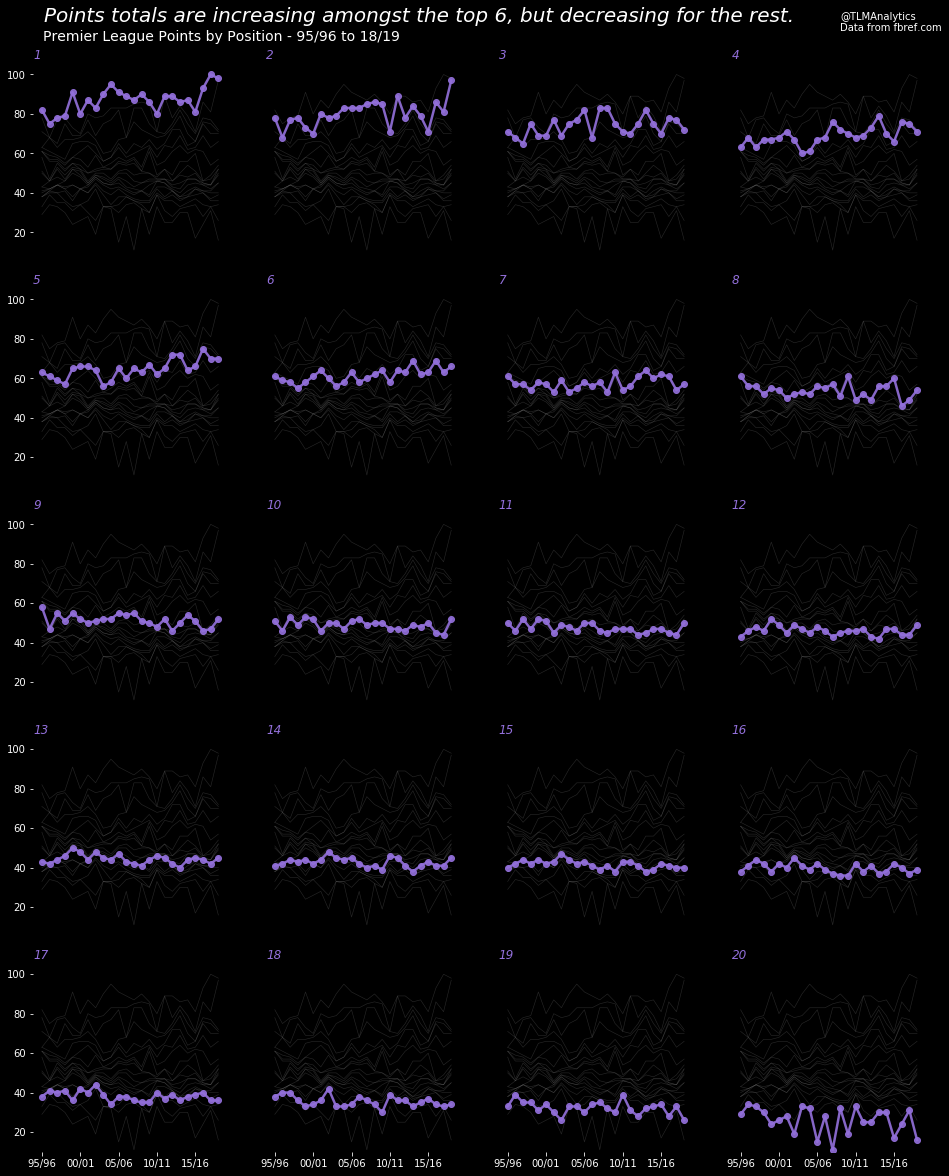

In [20]:
# Set universal plot style
plt.style.use('dark_background')
# Create figure
plt.figure(figsize=(16,20))
    
# Plot each position's plot in the defined subplot
position = 0
for pos in clean_points_positions.columns:
    position+=1
    individual_plot_points_totals(pos)
    
# Add supertitle and title    
plt.suptitle("Points totals are increasing amongst the top 6, but decreasing for the rest.", fontsize=20, color='white', style='italic', x=0.46, y=0.92)
plt.text(-91, 573, "Premier League Points by Position - 95/96 to 18/19", fontsize=14, color='white')

# Plug
plt.text(13, 578, "@TLMAnalytics\nData from fbref.com", fontsize=10)

# Save figure
plt.savefig("Premier League Points Totals by Position.png", bbox_inches='tight')

The approach to visualisation was directed by trying to avoid overplotting. On a single plot of all the data, it's hard to see trends for each specific line. Faceting solves this by separating each line on its own plot with the descending order making it easier to understand the visualisation as a whole. I included the greyed out other lines on each plot to clearer show the contrast between the individual plot and others.

## Gap between Champions and Survivors

### Data Wrangling

In [15]:
# Only keep champion (1) and the best relegated team (18)
gap_points_positions = clean_points_positions[[1, 18]]
# Calculate points required to survive
gap_points_positions['Survival'] = gap_points_positions[18] + 1
gap_points_positions

C:\Users\Ciaran\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Rk,1,18,Survival
Season,,,
95/96,82,38,39
96/97,75,40,41
97/98,78,40,41
98/99,79,36,37
99/00,91,33,34
00/01,80,34,35
01/02,87,36,37
02/03,83,42,43
03/04,90,33,34


### Create plot

In [16]:
def individual_plot_survival_dumbbell(pos):
    ymin = (gap_points_positions['Survival'].loc[pos] - ylim_min) / (ylim_max - ylim_min)
    ymax = (gap_points_positions[1].loc[pos] - ylim_min) / (ylim_max - ylim_min)
    ax.axvline(x=num, ymin=ymin, ymax=ymax, color='w', linestyle='dashed')

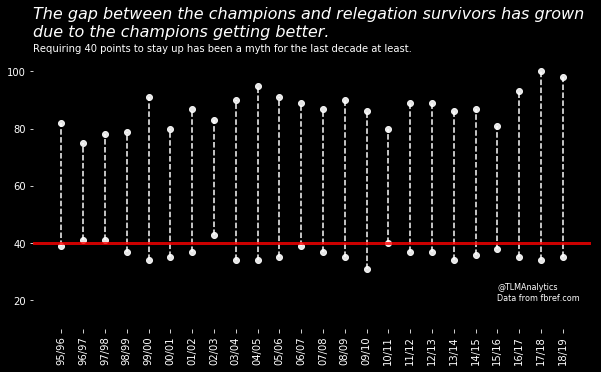

In [17]:
# Create figure
fig, ax = plt.subplots(figsize=(10,5))

# Set up axes formatting
plot_formatting()

# Plot champion and survivor dots
ax.scatter(gap_points_positions.index, gap_points_positions[1], marker='o', alpha=0.9, color = 'w')
ax.scatter(gap_points_positions.index, gap_points_positions['Survival'], marker='o', alpha=0.9, color = 'w')

# Set axis limits
ylim_max = 105
ylim_min = 10
ax.set_ylim(ylim_min,ylim_max)  

# Plot dashed line between champion and survivor 
num=0
for pos in gap_points_positions.index:
    individual_plot_survival_dumbbell(pos)
    num+=1

# Plot horizontal red line at 40 points
ax.axhline(y=40, color = 'r', alpha=0.8, linewidth = 3)

# Add supertitle and title
plt.suptitle("The gap between the champions and relegation survivors has grown\ndue to the champions getting better.",
             color = 'w', fontsize=16, ha='left', x=0.125, y=1.02, style='italic')
plt.title("Requiring 40 points to stay up has been a myth for the last decade at least.",
          color = 'w', fontsize=10, loc='left')

# Plug
plt.text(x=20, y=20, s="@TLMAnalytics\nData from fbref.com", fontsize=8, color='w')

# Save fig
plt.savefig("Champions and Survivors Gap.png", bbox_inches='tight')

The approach to visualisation was to highlight the difference between the two series. Without using the dotted connection between the two dots in ech year, it's harder to associate each dot with it's respective counterpart. The dotted line was used to try to dampen how pronounced the line was, as it's not the focus but just to enhance. The red horizontal line is a key point in football circles as the 40 point mark, which has been specified as required to avoid relegation. I've highlighted it here to try to denounce the myth and make it as clear as possible.

## Points required for Europe

### Data Wrangling

In [18]:
# Keep only the lowest team that could qualify for Champions league (4) and Europa League (7)
europe_points_positions = clean_points_positions[[4, 7]]
europe_points_positions

Rk,4,7
Season,,
95/96,63,61
96/97,68,57
97/98,63,57
98/99,67,54
99/00,67,58
00/01,68,57
01/02,71,53
02/03,67,59
03/04,60,53


### Create plot

C:\Users\Ciaran\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Ciaran\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ciaran\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


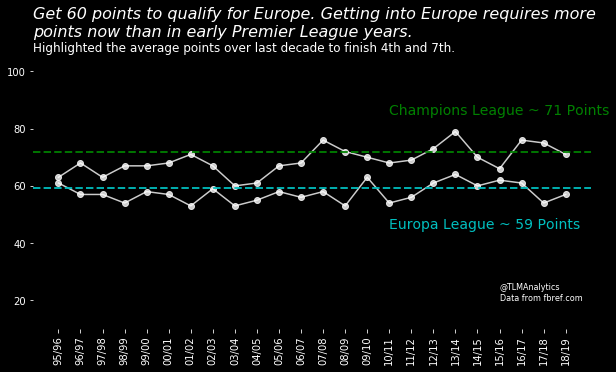

In [19]:
# Create figure
fig, ax = plt.subplots(figsize=(10,5))

# Set up axes formatting
plot_formatting()

# Plot each line
ax.plot(europe_points_positions.index, europe_points_positions[4], marker='o', alpha=0.8, color = 'w')
ax.plot(europe_points_positions.index, europe_points_positions[7], marker='o', alpha=0.8, color = 'w')

# Set axis limits
ylim_max = 105
ylim_min = 10
ax.set_ylim(ylim_min,ylim_max)

# Add horizontal line for average points totals
ax.axhline(y=europe_points_positions[4][-10:].mean(), color = 'g', alpha=0.9, linewidth = 2, linestyle='dashed')
ax.axhline(y=europe_points_positions[7][-10:].mean(), color = 'c', alpha=0.9, linewidth = 2, linestyle='dashed')

# Add label annotation
plt.text(x=15, y=85, s='Champions League ~ 71 Points', color='g', fontsize=14)
plt.text(x=15, y=45, s='Europa League ~ 59 Points', color='c', fontsize=14)

# Add supertitle and title
plt.suptitle("Get 60 points to qualify for Europe. Getting into Europe requires more\npoints now than in early Premier League years.",
             color = 'w', fontsize=16, ha='left', x=0.125, y=1.02, style='italic')
plt.title("Highlighted the average points over last decade to finish 4th and 7th.",
          color = 'w', fontsize=12, loc='left')

# Plug
plt.text(x=20, y=20, s="@TLMAnalytics\nData from fbref.com", fontsize=8, color='w')

# Save
plt.savefig("Qualifying for Europe.png", bbox_inches='tight')

The approach to visualisation here was to highlight the trend of each series through time. Both trend slightly upwards and I've used an average here to try to enhance understanding and make it clearer that most of the points in the past are under this line but recent points are above or close to it.